In [1]:
import os
import pandas as pd
from gplearn.genetic import SymbolicRegressor
from sklearn.utils.random import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import metrics
from sympy import *
import pickle
from Fancy_aggregations import owas, integrals
from plotnine import ggplot, aes, geom_boxplot,  labs, geom_segment, coord_cartesian, scale_x_discrete, theme, element_text
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
def generate_plot(data,name):
    #age_mean=np.mean(data['Age'])
    p = (ggplot(data, aes(x='Age', y='prediction', group='Age'))
       # + geom_hline(yintercept=age_mean, color='black', linetype='dashed')
        + geom_boxplot(color='steelblue', fill='lightblue')
        + labs(x='Actual Age', y='Estimated Age', title=name)
        + geom_segment(aes(x=min(data['Age']), y=min(data['Age']), xend=max(data['Age']), yend=max(data['Age'])),
                        linetype='dotted', color='black')
        + coord_cartesian(xlim=(min(data['Age']), max(data['Age'])), ylim=(min(data['Age']), max(data['Age']))))
    return p

## Read & Process Data, cleanup NAs, save clean data

In [3]:
def extract_dataframes(file_path):
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names
    dfs = {}
    for sheet_name in sheet_names:
        df = xls.parse(sheet_name)
        dfs[sheet_name] = df
    xls.close()
    return dfs,sheet_names

file_path =  './data_updated.xlsx'
data_dir=os.path.dirname(file_path) 
result,sheet_names = extract_dataframes(file_path)

In [4]:
def process_dataframes_and_filter_na(result_dataframes):
    processed_dfs = {}
    for sheet_name, df in result_dataframes.items():
        filtered_df = df[df.apply(lambda row: any(pd.isna(cell) or cell == '-' for cell in row), axis=1)]
        processed_dfs[sheet_name] = filtered_df[['id','Laterality']]
    return processed_dfs

def clean_results(result_dataframes,query_dataframe):
    clean_dfs = {}
    for sheet_name, df in result_dataframes.items():
        merged_df = pd.merge(df, query_dataframe, on=['id', 'Laterality'], how='left', indicator=True)
        merged_df = merged_df.drop(merged_df[merged_df.Age > 60].index)
        merged_df = merged_df.drop(merged_df[merged_df.Age < 18].index)
        merged_df = merged_df.drop(merged_df[merged_df.id.isin([514])].index)

        clean_dfs[sheet_name] = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1).astype('int64')
        
    return clean_dfs

processed_dataframes = process_dataframes_and_filter_na(result)
concatenated_df = pd.concat(processed_dataframes.values(), ignore_index=True)
joined_dataframe = concatenated_df.drop_duplicates() 
clean_result_dfs=clean_results(result,joined_dataframe)
with pd.ExcelWriter(os.path.join(data_dir,"clean_data_after_processing.xlsx")) as writer:    
    for sheet_name, df in clean_result_dfs.items():
        df.to_excel(writer,sheet_name=sheet_name,index=False)

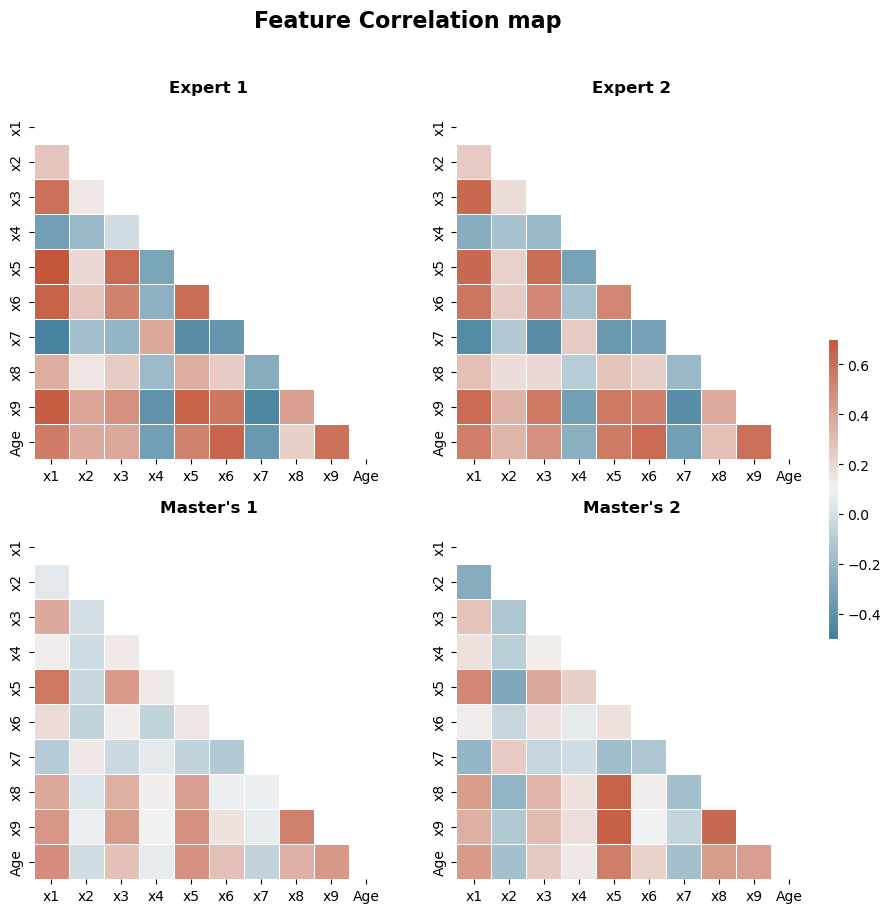

In [5]:
names={'E1':'Expert 1','E2':'Expert 2', 'M1':'Master\'s 1','M2':'Master\'s 2'}
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
i=0 
fig.suptitle('Feature Correlation map',weight='bold', fontsize=16)

axes=axes.flatten()
for sheet_name, df in clean_result_dfs.items():
    corr_mat = df.drop(['id','Laterality','Phase'],axis=1).corr()

    # Set plot size
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    # Plot heatmap
    hm=sns.heatmap(data=corr_mat,mask=mask,
            square=True, robust=True, 
            cmap=cmap,  vmin=-0.5, vmax=0.7,
            cbar=False, # shrink colour bar
            linewidth=0.5,ax=axes[i])# space between cells
    hm.set_title(''+names[sheet_name], fontdict={'fontsize':12,'weight':'bold'}, pad=12)
    i=i+1
cbar_ax = fig.add_axes([0.92, 0.35, 0.01, 0.3])  # Adjust the position as needed

cbar = plt.colorbar(axes[0].collections[0], cax=cbar_ax)
cbar.outline.set_color('white')

plt.savefig("Ensemble_cm.svg", format='svg')
plt.show()

## Data Partition 1.0

In [6]:
#Sort&Prepare indexes
for sheet_name, df in clean_result_dfs.items():
    clean_result_dfs[sheet_name]=clean_result_dfs[sheet_name].sort_values(by=['id','Laterality'])

for sheet_name, df in clean_result_dfs.items():
    clean_result_dfs[sheet_name]=clean_result_dfs[sheet_name].reset_index(drop=True)
    
for sheet_name, df in clean_result_dfs.items():
    clean_result_dfs[sheet_name]=clean_result_dfs[sheet_name].reset_index()
    
#Taking indexes from E1 labels and splitting
X_idx=clean_result_dfs['E1']['index']
y_idx=clean_result_dfs['E1']['Age']
X_idx_train, X_idx_test, y_idx_train, y_idx_test = train_test_split(X_idx, y_idx, test_size=0.2, random_state=1, stratify=y_idx)



In [7]:
print("Size of Data Set: ",  len(clean_result_dfs['E1']))
print("Min age: ",min(clean_result_dfs['E1']['Age']))
print("Max age: ",max(clean_result_dfs['E1']['Age']))
print("Individuals",len(clean_result_dfs['E1']['id'].unique()))

print("Laterality Left: ", len(clean_result_dfs['E1'][clean_result_dfs['E1']['Laterality']==0]))
print("Laterality Right:", len(clean_result_dfs['E1'][clean_result_dfs['E1']['Laterality']==1]))


Size of Data Set:  986
Min age:  18
Max age:  60
Individuals 497
Laterality Left:  493
Laterality Right: 493


In [8]:
#Slice each dataframe using splitted indexes to avoid data contamination
training_data= {}
testing_data= {}
for sheet_name, df in clean_result_dfs.items():
    training_data[sheet_name]=clean_result_dfs[sheet_name][clean_result_dfs[sheet_name]['index'].isin(X_idx_train)]
    testing_data[sheet_name]=clean_result_dfs[sheet_name][clean_result_dfs[sheet_name]['index'].isin(X_idx_test)]

#Aggregate data
frames_train = [f for s,f in training_data.items()]
frames_test = [f for s,f in testing_data.items()]
training_agg=pd.concat(frames_train)
testing_agg=pd.concat(frames_test)

training_exp=pd.concat([training_data['E1'],training_data['E2']])
testing_exp=pd.concat([testing_data['E1'],testing_data['E2']])

In [9]:
#Verify Stats are correct when aggregated - not essential
frames_agg=[training_agg,testing_agg]

agg_all_data=pd.concat(frames_agg)

agg_all_data=agg_all_data.sort_values(by=['id', 'Laterality'])
agg_all_data=agg_all_data.reset_index(drop=True)

print("Size Aggregation: ",  len(agg_all_data))
print("Laterality Left: ", len(agg_all_data[agg_all_data['Laterality']==0]))
print("Laterality Right:", len(agg_all_data[agg_all_data['Laterality']==1]))


Size Aggregation:  3944
Laterality Left:  1973
Laterality Right: 1971


In [10]:
concat=pd.concat((clean_result_dfs['E1'],clean_result_dfs['E2'],clean_result_dfs['M1'],clean_result_dfs['M2']))
avg_all=concat.groupby(concat.index).mean().apply(np.floor)
training_data['avg_all']=avg_all[avg_all['index'].isin(X_idx_train)]
testing_data['avg_all']=avg_all[avg_all['index'].isin(X_idx_test)]

concat=pd.concat((clean_result_dfs['E1'],clean_result_dfs['E2']))
avg_exp=concat.groupby(concat.index).mean().apply(np.floor)
training_data['avg_exp']=avg_exp[avg_exp['index'].isin(X_idx_train)]
testing_data['avg_exp']=avg_exp[avg_exp['index'].isin(X_idx_test)]

# PG Logic for basic experiments

In [11]:

def fit_SR_model(X_train, y_train,function_set):
    est_gp = SymbolicRegressor(population_size=1000, function_set=function_set, metric='mse',
                            generations=1000, tournament_size=80, stopping_criteria=0.01,
                            p_crossover=0.75, p_subtree_mutation=0.11,
                            p_hoist_mutation=0.08, p_point_mutation=0.05,
                            max_samples=1, verbose=1,
                            parsimony_coefficient=0.05, random_state=0)
    est_gp.fit(X_train, y_train)
    return est_gp

In [12]:
data_eval={'X_train':{},'y_train':{},'X_test':{},'y_test':{}}
for sheet_name, df in training_data.items():
    # Training samples
    data_eval['X_train'][sheet_name] = training_data[sheet_name].drop(columns=['index','id','Laterality','Phase','Age'])
    data_eval['y_train'][sheet_name] = training_data[sheet_name]['Age']

    # Testing samples
    data_eval['X_test'][sheet_name] = testing_data[sheet_name].drop(columns=['index','id','Laterality','Phase','Age'])
    data_eval['y_test'][sheet_name] = testing_data[sheet_name]['Age']
    print('Train size: ',sheet_name,len(data_eval['y_train'][sheet_name]))
    print('Test size:  ',sheet_name,len(data_eval['y_test'][sheet_name]))

#shuffle
training_agg = training_agg.sample(frac = 1)
testing_agg = testing_agg.sample(frac = 1)

training_exp = training_exp.sample(frac = 1)
testing_exp = testing_exp.sample(frac = 1)

data_eval['X_train']['Agg_data'] = training_agg.drop(columns=['index','id','Laterality','Phase','Age'])
data_eval['y_train']['Agg_data'] = training_agg['Age']

# Testing samples
data_eval['X_test']['Agg_data'] = testing_agg.drop(columns=['index','id','Laterality','Phase','Age'])
data_eval['y_test']['Agg_data'] = testing_agg['Age']

data_eval['X_train']['Expert_data'] = training_exp.drop(columns=['index','id','Laterality','Phase','Age'])
data_eval['y_train']['Expert_data'] = training_exp['Age']

# Testing samples
data_eval['X_test']['Expert_data'] = testing_exp.drop(columns=['index','id','Laterality','Phase','Age'])
data_eval['y_test']['Expert_data'] = testing_exp['Age']

print('Train size: ','Agg_data',len(data_eval['y_train']['Agg_data']))
print('Test size:  ','Agg_data',len(data_eval['y_test']['Agg_data']))

print('Train size: ','Expert_data',len(data_eval['y_train']['Expert_data']))
print('Test size:  ','Expert_data',len(data_eval['y_test']['Expert_data']))

Train size:  E1 788
Test size:   E1 198
Train size:  E2 788
Test size:   E2 198
Train size:  M1 788
Test size:   M1 198
Train size:  M2 788
Test size:   M2 198
Train size:  avg_all 788
Test size:   avg_all 198
Train size:  avg_exp 788
Test size:   avg_exp 198
Train size:  Agg_data 3152
Test size:   Agg_data 792
Train size:  Expert_data 1576
Test size:   Expert_data 396


In [13]:
function_set = ['add', 'sub', 'mul', 'div','neg','inv']
SR_models={}
SR_test_results={}
SR_test_predictions={}
SR_train_results={}

for sheet_name, df in  data_eval['X_train'].items():
   SR_models[sheet_name]=fit_SR_model( data_eval['X_train'][sheet_name], data_eval['y_train'][sheet_name] ,function_set)

   y_test_SR=SR_models[sheet_name].predict(data_eval['X_test'][sheet_name])
   test_metric_mae=metrics.mean_absolute_error(data_eval['y_test'][sheet_name],y_test_SR)
   test_metric_rmse=metrics.mean_squared_error(data_eval['y_test'][sheet_name],y_test_SR,squared=False)
   test_score= SR_models[sheet_name].score(data_eval['X_test'][sheet_name],data_eval['y_test'][sheet_name])
   SR_train_results[sheet_name]={'R2_score':SR_models[sheet_name].score(data_eval['X_train'][sheet_name],data_eval['y_train'][sheet_name])}
   SR_test_results[sheet_name]={'R2_score':test_score,'mae':test_metric_mae,'rmse':test_metric_rmse}
   SR_test_predictions[sheet_name]=y_test_SR

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.78          13775.3        4          367.494              N/A      5.05m
   1    24.24          2204.35       14          138.049              N/A      6.55m
   2    17.87          15625.8       19          101.784              N/A      5.67m
   3    13.92          7661.49       30          94.3871              N/A      5.54m
   4    19.86          8582.08       23          87.2519              N/A      5.98m
   5    23.79          7111.61       20           84.208              N/A      5.89m
   6    24.00          7524.42       20          80.3044              N/A      5.86m
   7    22.31          10662.3       25          76.8253              N/A      7.04m
   8    23.37          8248.54       27          75.1943              N/A  

In [14]:
for sheet_name, df in  data_eval['X_train'].items():
    with open('models/'+sheet_name+'.pkl', 'wb') as f:
        pickle.dump(SR_models[sheet_name], f)

### OPTIONAL: LOADING MODELS FROM FILE

In [49]:
SR_models={}
SR_test_results={}
SR_test_predictions={}
SR_train_results={}
for sheet in ['E1','E2','M1','M2','Agg_data','Expert_data','avg_all','avg_exp']:
    with open('models/'+sheet+'.pkl', 'rb') as f:
        est = pickle.load(f)
        SR_models[sheet]=est


for sheet_name, df in  data_eval['X_train'].items():
   y_test_SR=SR_models[sheet_name].predict(data_eval['X_test'][sheet_name])
   test_metric_mae=metrics.mean_absolute_error(data_eval['y_test'][sheet_name],y_test_SR)
   test_metric_rmse=metrics.mean_squared_error(data_eval['y_test'][sheet_name],y_test_SR,squared=False)

   SR_train_results[sheet_name]={'R2_score':SR_models[sheet_name].score(data_eval['X_train'][sheet_name],data_eval['y_train'][sheet_name])}
   SR_test_results[sheet_name]={'mae':test_metric_mae,'rmse':test_metric_rmse}
   SR_test_predictions[sheet_name]=y_test_SR

## Results

In [50]:
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y, 
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}


simplified_equations={}
for sheet_name, df in  data_eval['X_train'].items():
    print(sheet_name,' -  Depth: ',SR_models[sheet_name]._program.depth_,' - Length: ',SR_models[sheet_name]._program.length_)
    print('Test: ',SR_test_results[sheet_name])
    simplified_equations[sheet_name] = sympify((SR_models[sheet_name]), locals=converter)
    print("Simplified equation")
    print(simplified_equations[sheet_name],'\n')



E1  -  Depth:  15  - Length:  63
Test:  {'mae': 6.611699336942163, 'rmse': 8.152097432583801}
Simplified equation
2*X1 + X3/X5 + 12.7058823529412*X5 + X5/(-X5 + X8/X4) + X8 + 2.710027100271 - 0.249/X7 + (X2 + X3)*(X0/X5**2 + X1)/X5 + X8/X4 + 11.6279069767442*X4/(X3*(X5 + X8)) 

E2  -  Depth:  18  - Length:  90
Test:  {'mae': 6.196953602084002, 'rmse': 7.767587777446707}
Simplified equation
2*X0 + X1 + 7*X2 - 3*X4 + 11.6279069767442*X4/(-X2 + X4) + 6.70588235294118*X5 + 3*X8 + 2.931 - 1/(-X5 + X7 - 0.476) - 1/(X5 - 0.596) + 1/(X1*X2) + 1/(X1*X2*X5) 

M1  -  Depth:  20  - Length:  67
Test:  {'mae': 7.692395114517578, 'rmse': 9.208711043770798}
Simplified equation
3*X0 + X0/X7 + X4*(-X0/X7 + 11.6279069767442*X4)/X5 + 9.70588235294118*X5 + X7 + 2*X8 + 1.03404737732657 - 1/(-X5 - 0.086) 

M2  -  Depth:  12  - Length:  60
Test:  {'mae': 7.399510131004906, 'rmse': 8.913666242715125}
Simplified equation
X0*X4 + X0/(-X4 + X5) - X1 + 2*X2 + X4*X5 + 2*X4 + X5*(X7 + 0.529*X8) - X6 - (-X1 + X2)*(-X

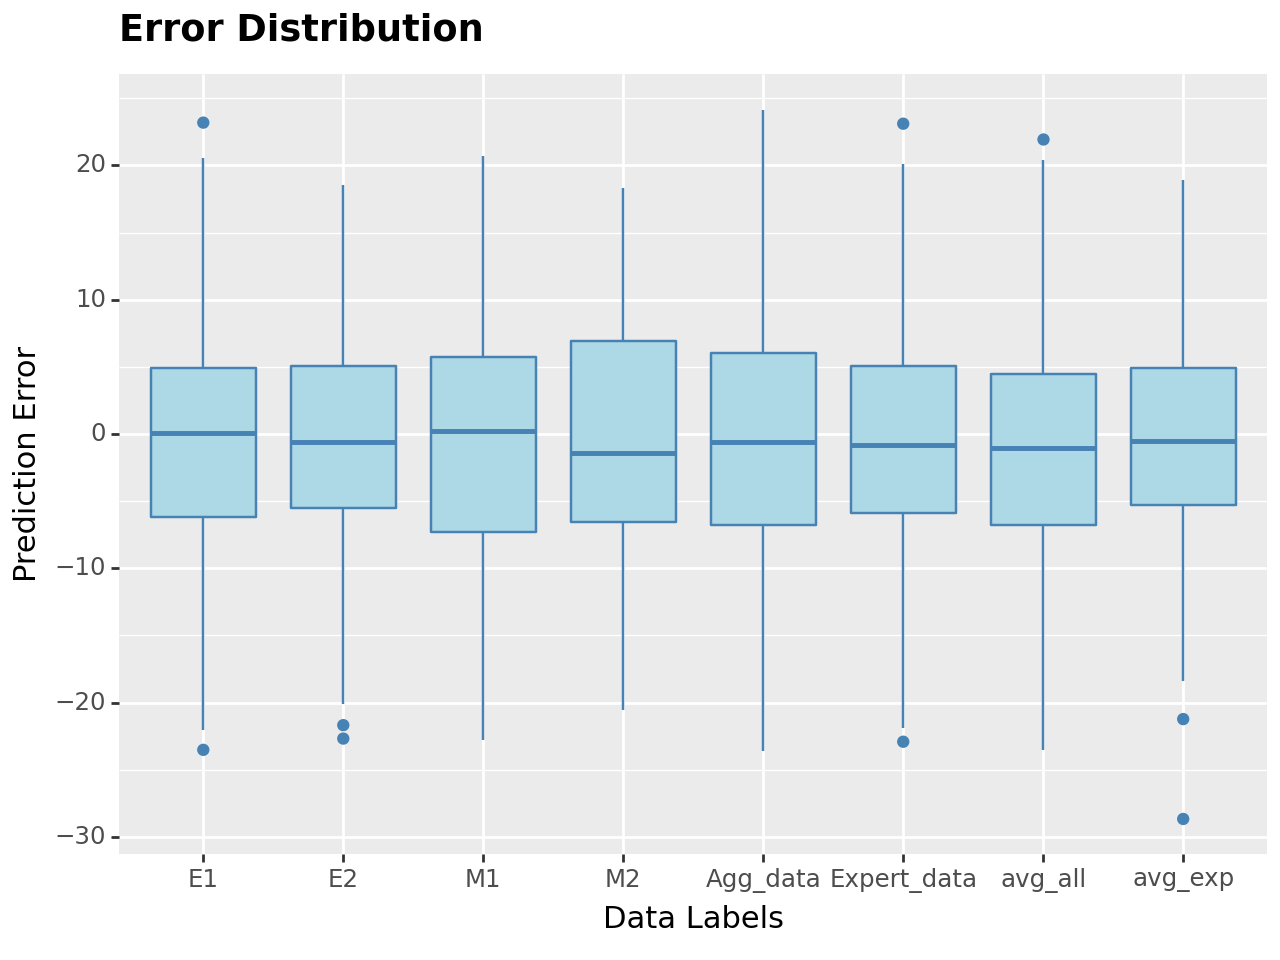

In [51]:
data={}
for sheet_name, df in  data_eval['X_train'].items():
    data[sheet_name]=pd.DataFrame({'Data Labels':sheet_name, 'Prediction Error':data_eval['y_test'][sheet_name]-SR_test_predictions[sheet_name]})

df_frame=[f for s,f in data.items()]
df=pd.concat(df_frame)
list_x=['E1','E2','M1','M2','Agg_data','Expert_data','avg_all','avg_exp']
p=(ggplot(df, aes(x='Data Labels', y='Prediction Error' ))
   + geom_boxplot(color='steelblue', fill='lightblue')
 + scale_x_discrete(limits=list_x)+
 labs(title="Error Distribution"))+ theme(plot_title=element_text(weight='bold'))
print(p)

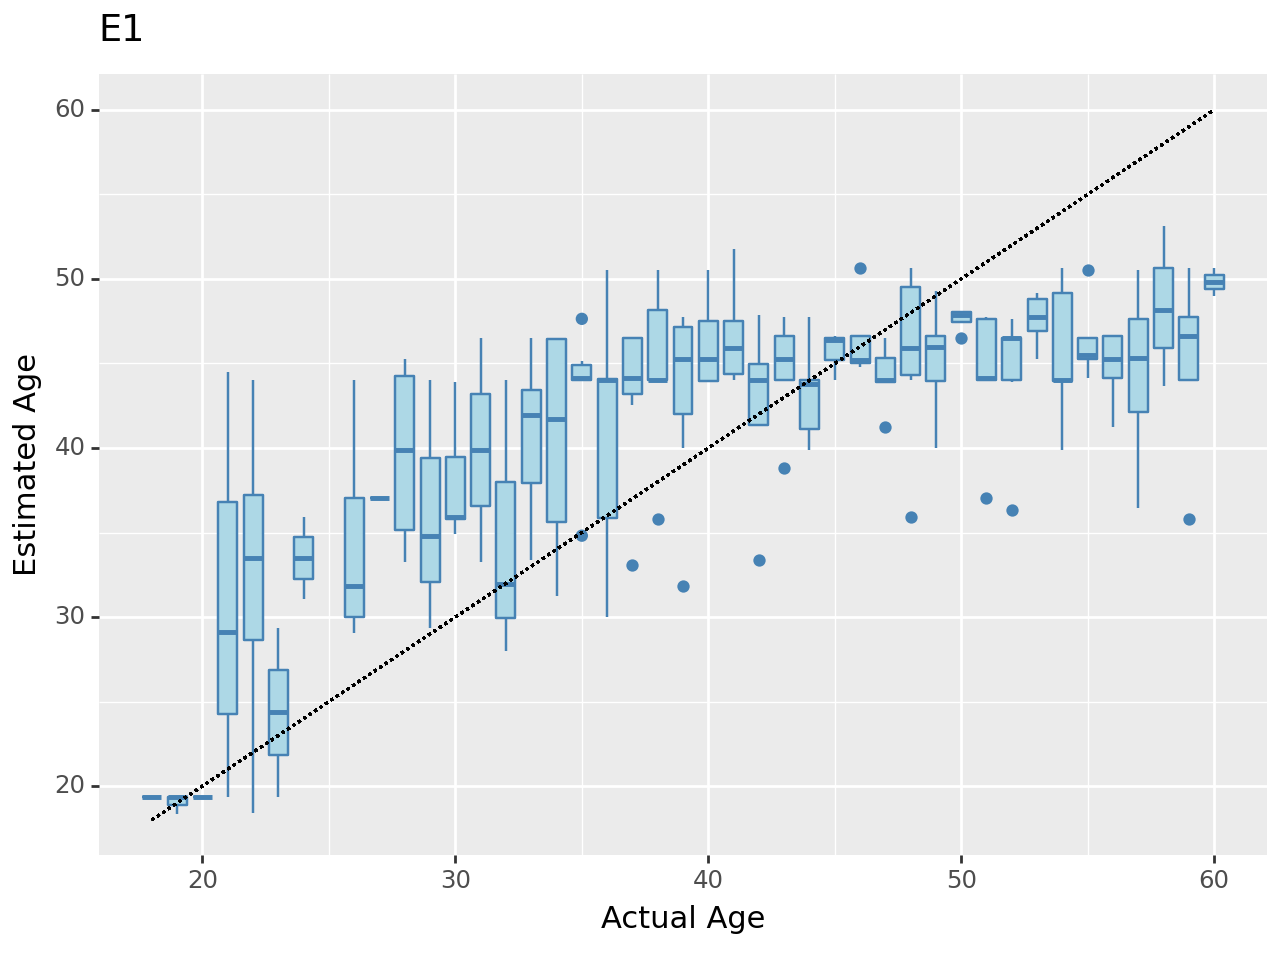

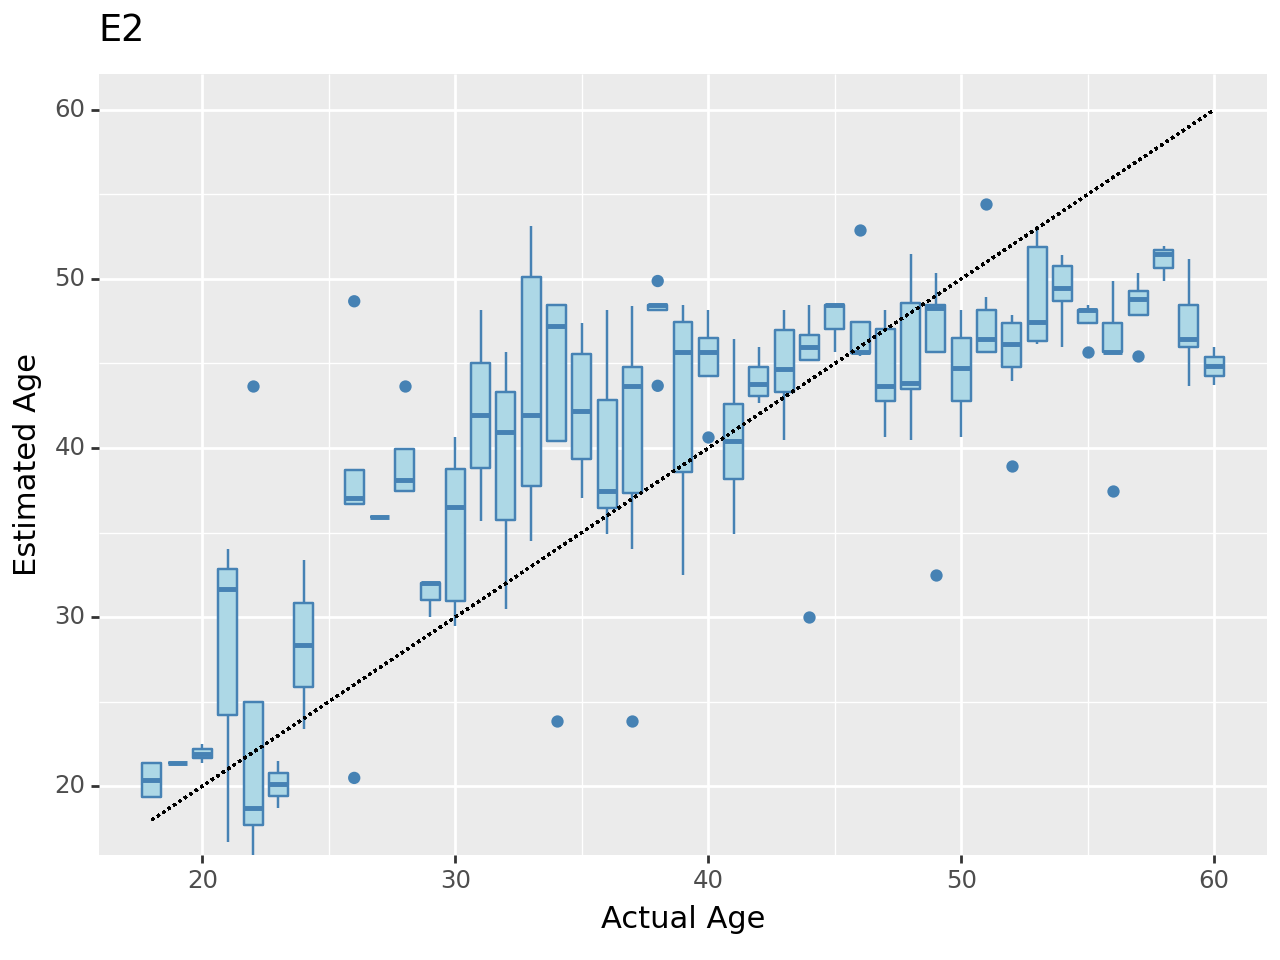

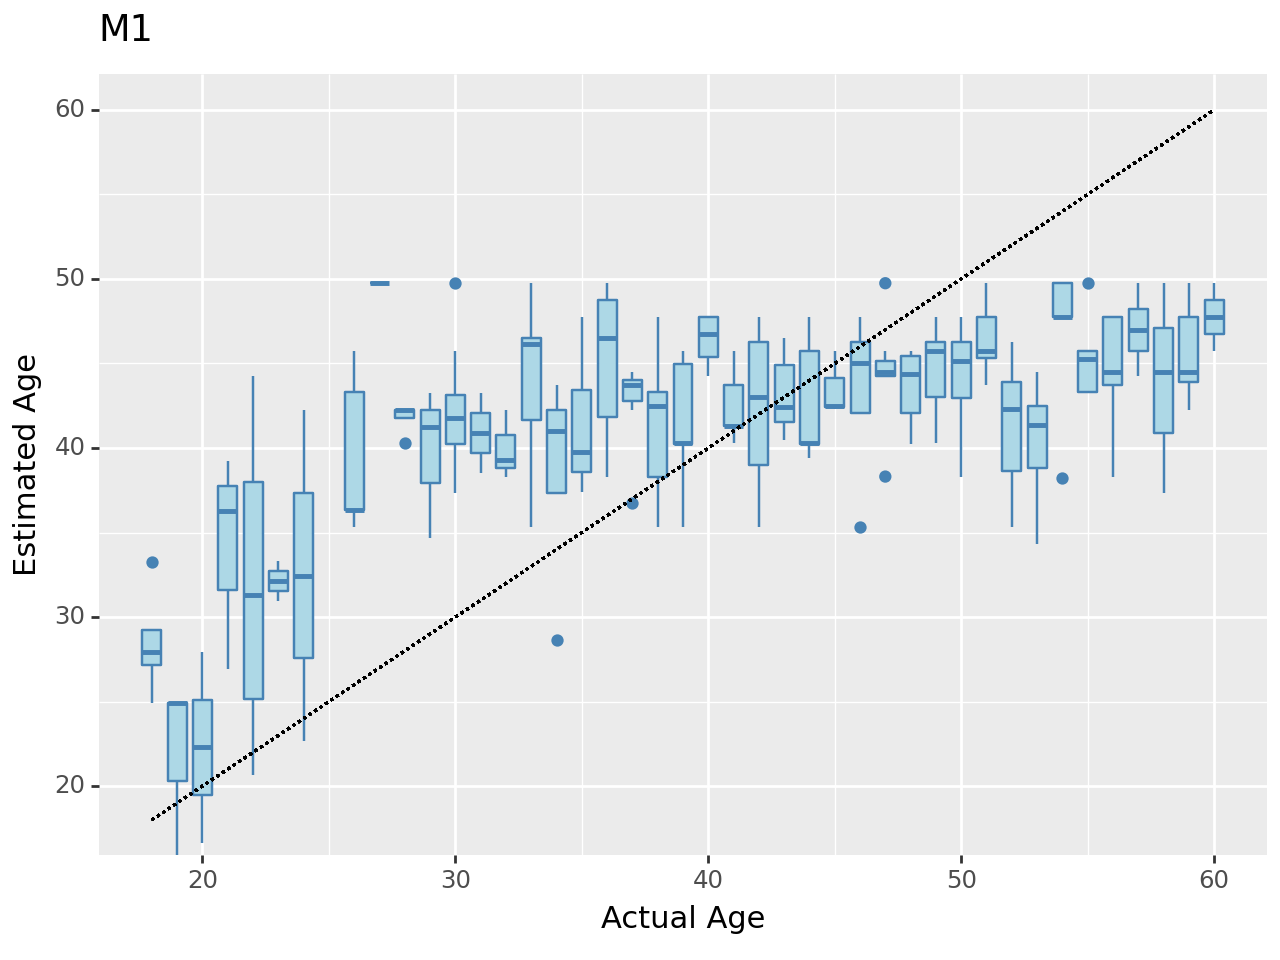

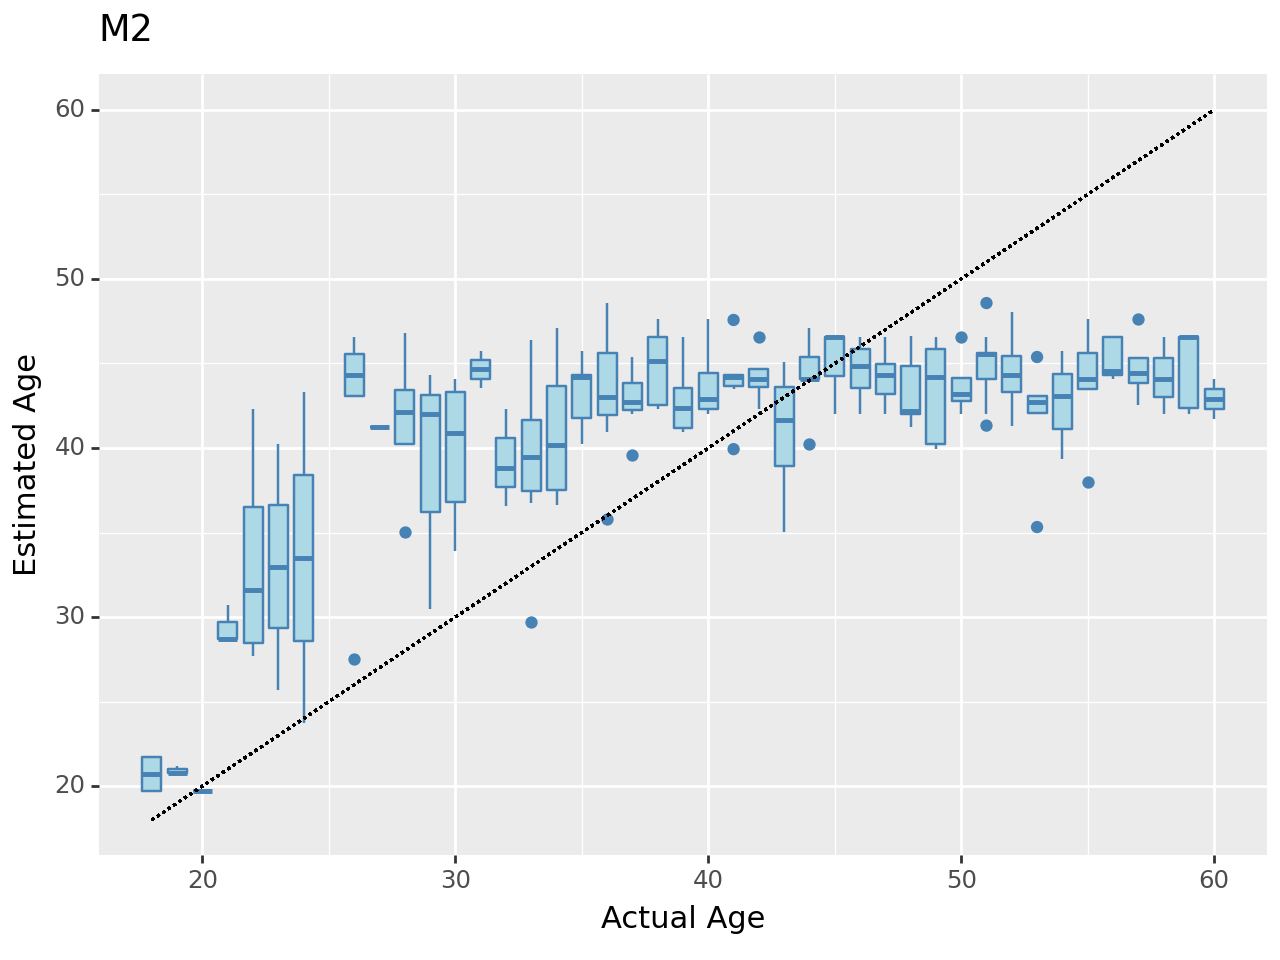

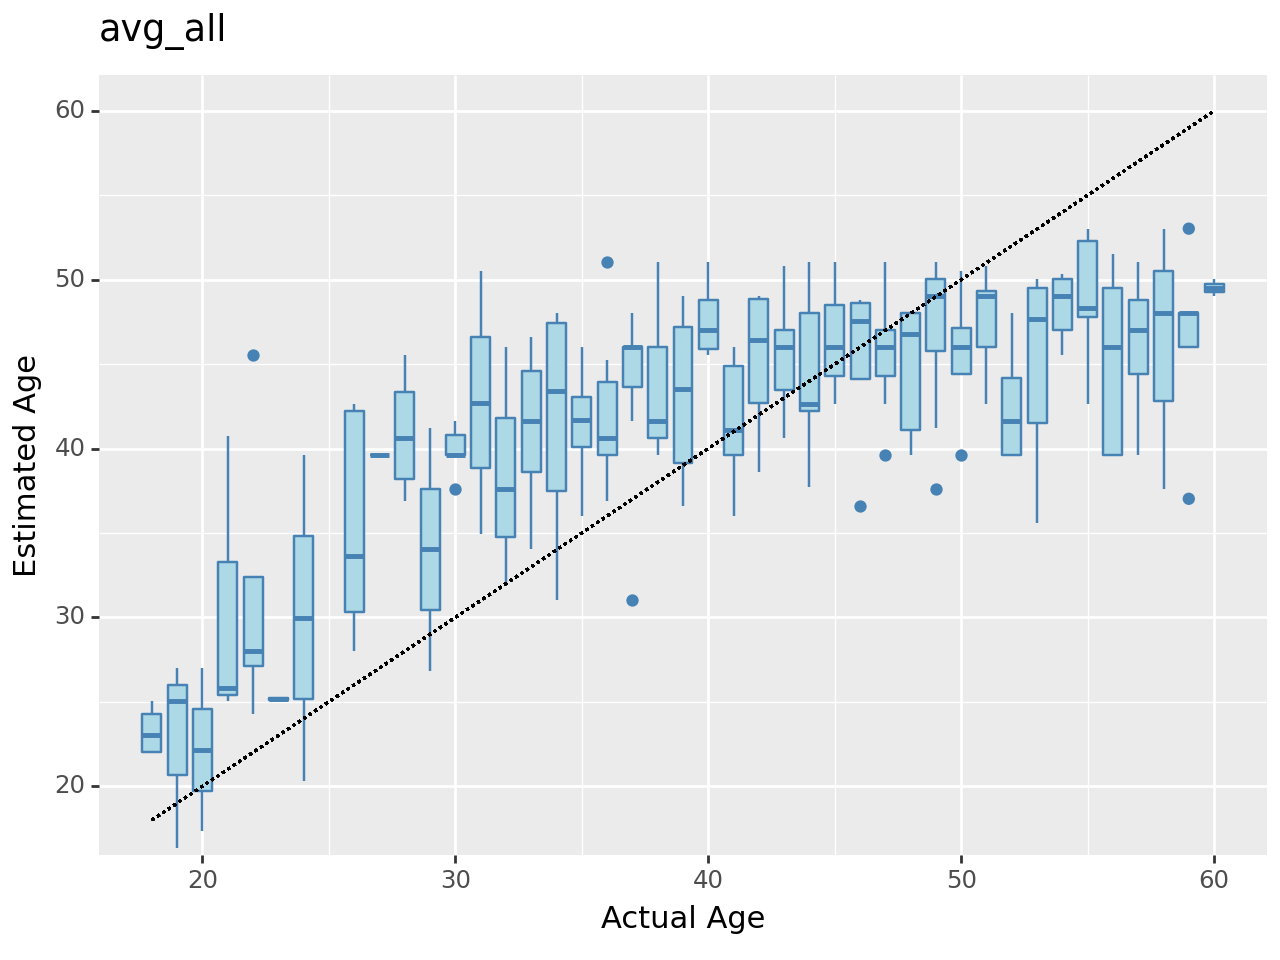

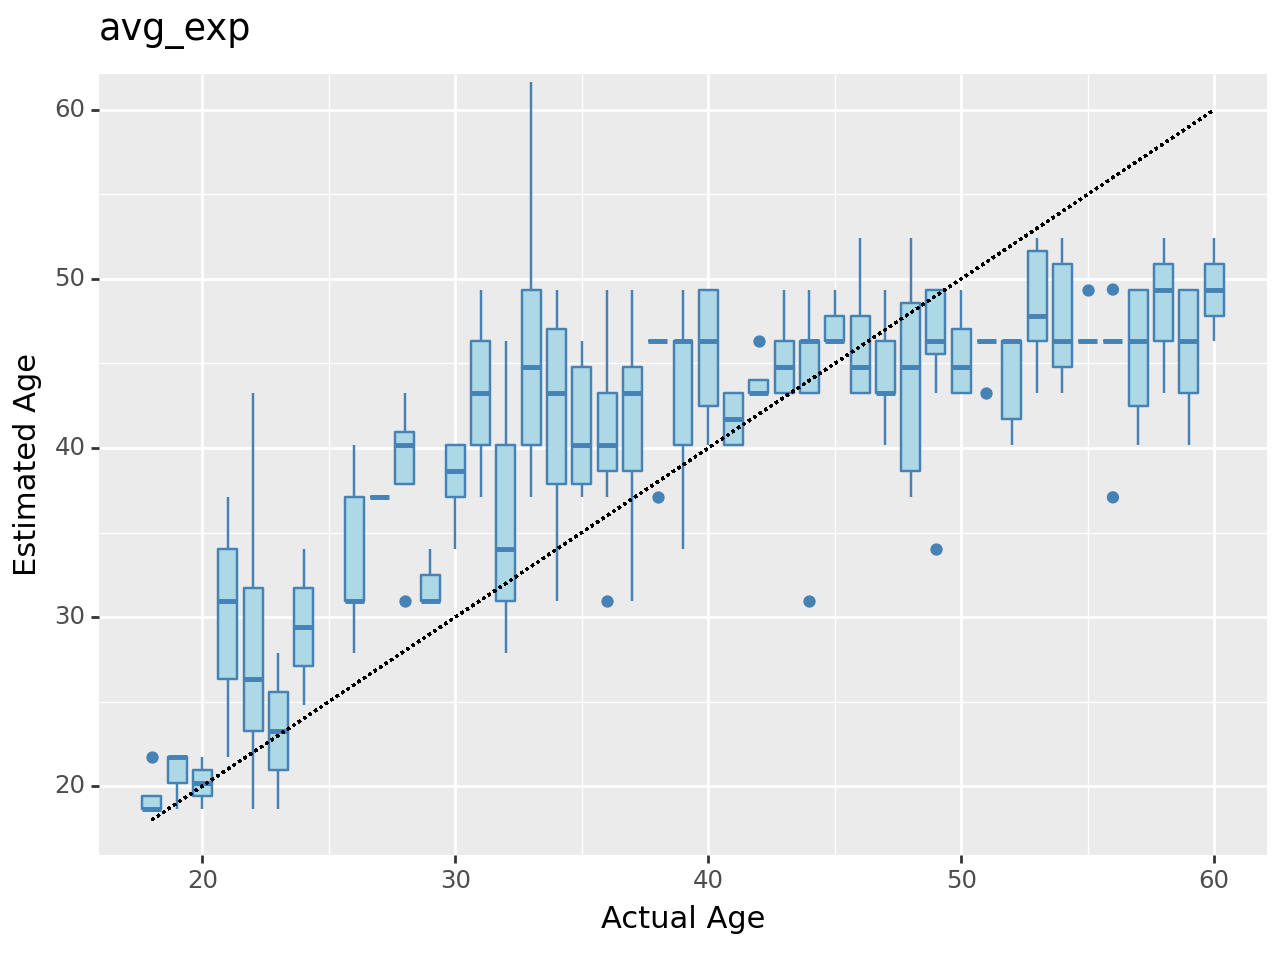

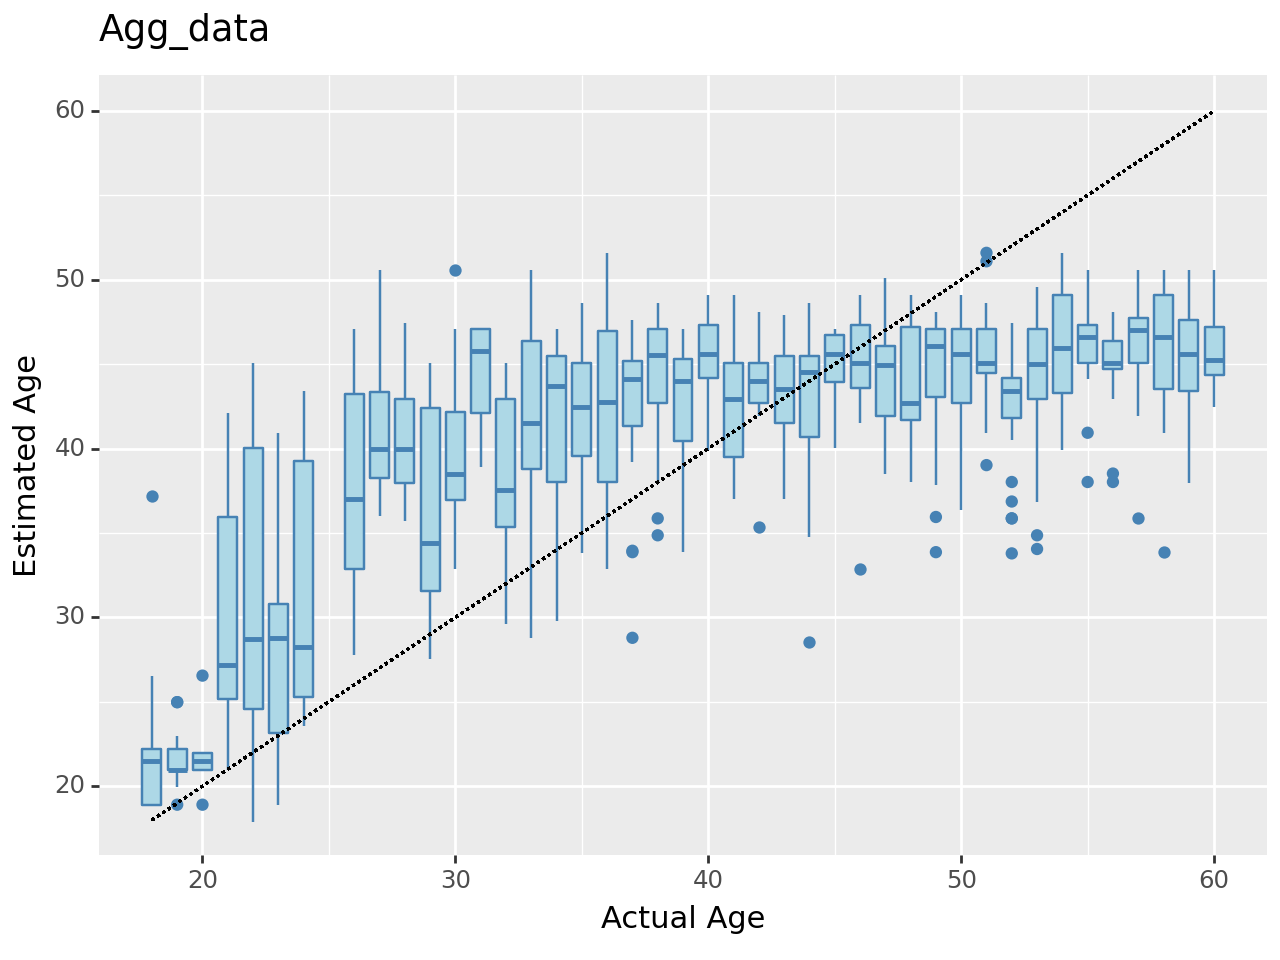

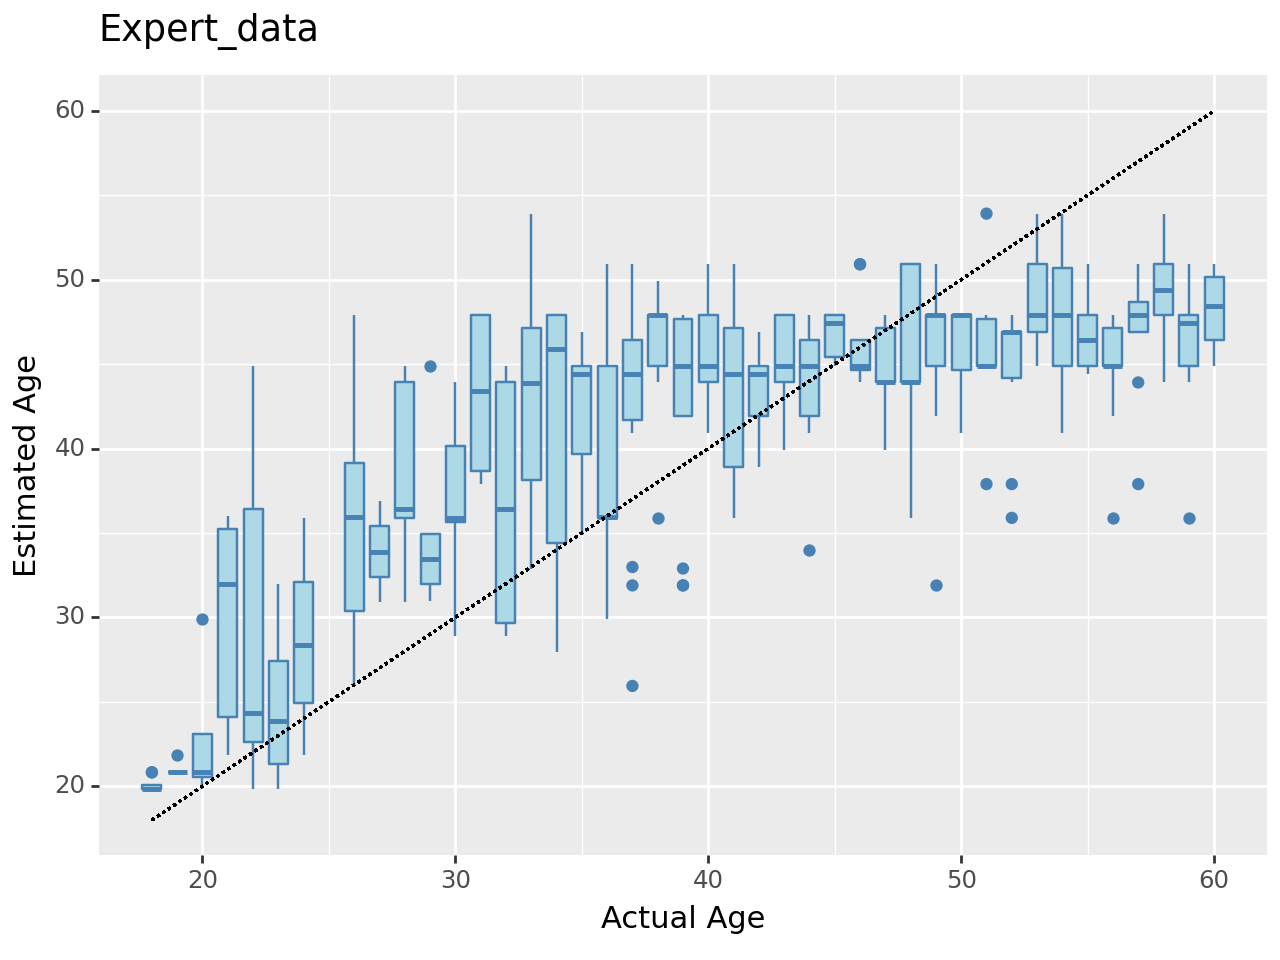

In [52]:

for sheet_name, df in  data_eval['X_train'].items():
     p=generate_plot(pd.DataFrame({'Age': data_eval['y_test'][sheet_name], 'prediction':SR_test_predictions[sheet_name]}),sheet_name)
     # Print the plot
     print(p)


# Ensembles

In [53]:
#Retrieval
test_pred_E1=SR_test_predictions['E1']
test_pred_E2=SR_test_predictions['E2']
test_pred_M1=SR_test_predictions['M1']
test_pred_M2=SR_test_predictions['M2']

### SAE: Simple Average - Regression Voting

In [54]:

test_pred_ensembleSAE1=(test_pred_E1+test_pred_M1+test_pred_M2+test_pred_E2)/4
test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensembleSAE1)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensembleSAE1)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensembleSAE1,squared=False)
   
SAE1_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating 4 labels',SAE1_test_results)

Aggregating 4 labels {'mae': 6.561341245601311, 'mse': 61.20831213872203, 'rmse': 7.82357412815409}


In [55]:
test_pred_ensembleSAE1_pruned=(test_pred_E1+test_pred_E2)/2
test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensembleSAE1_pruned)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensembleSAE1_pruned)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensembleSAE1_pruned,squared=False)
   
SAE1_test_results_pruned={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating Experts',SAE1_test_results_pruned)

Aggregating Experts {'mae': 6.148990013211115, 'mse': 56.93319258933767, 'rmse': 7.545408709230911}


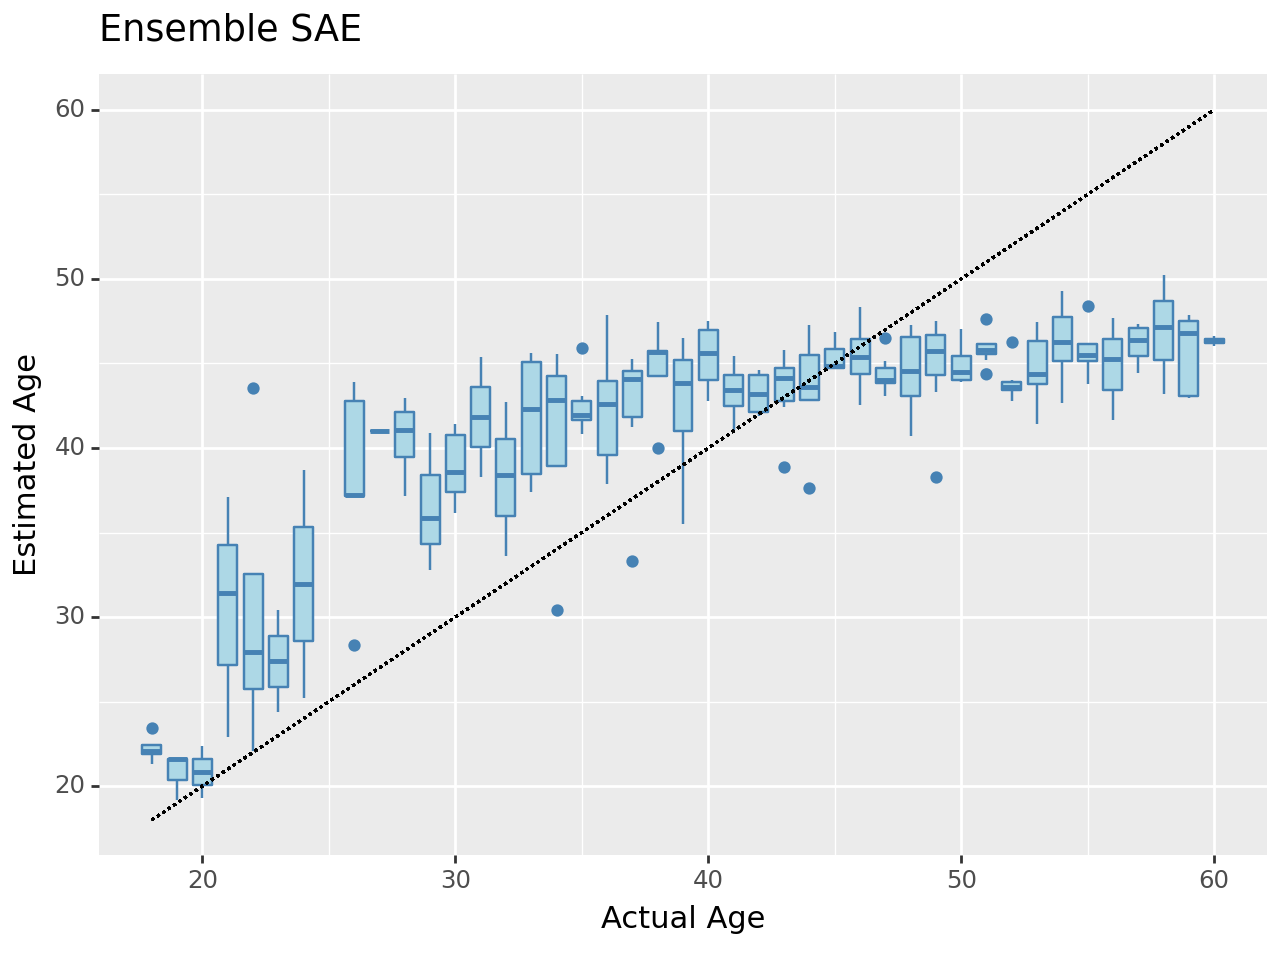

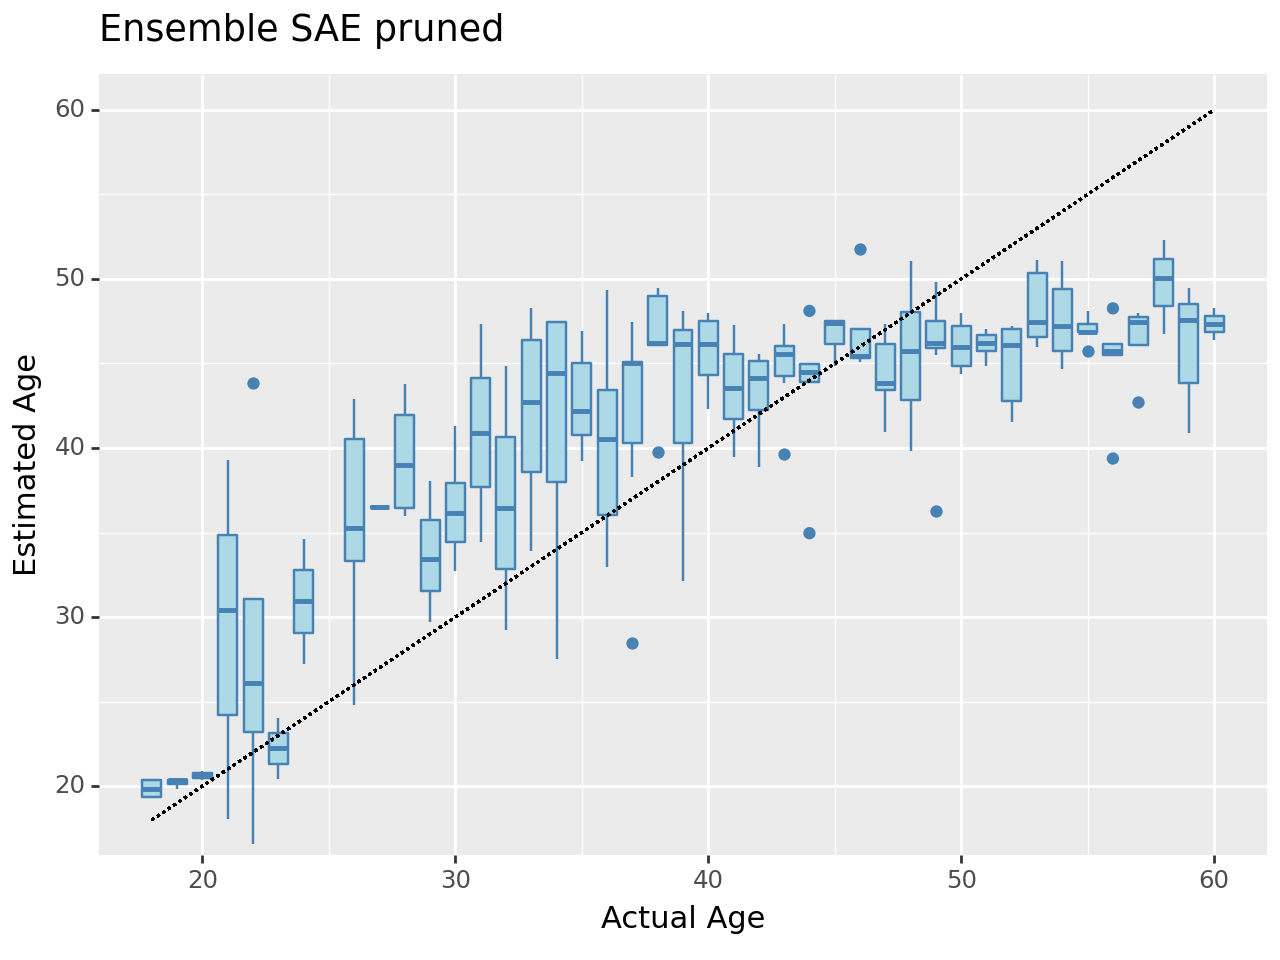

In [56]:

p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensembleSAE1}),'Ensemble SAE')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensembleSAE1_pruned}),'Ensemble SAE pruned')
print(p)


### WAE: Weighted Average by Expertise

In [57]:

ws=np.array([2,2,1,1])
normalized_weights = normalize(ws.reshape(1, -1), norm='l1')[0]

test_pred_ensembleWAE2=(test_pred_E1*normalized_weights[0]+test_pred_E2*normalized_weights[1]+test_pred_M1*normalized_weights[2]+test_pred_M2*normalized_weights[3])

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensembleWAE2)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensembleWAE2)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensembleWAE2,squared=False)
   

WAE2_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating 4 labels',WAE2_test_results)

Aggregating 4 labels {'mae': 6.3594384286354, 'mse': 58.609208921073545, 'rmse': 7.655665152099688}


In [58]:

ws=np.array([1.5,2,0,0])
normalized_weights = normalize(ws.reshape(1, -1), norm='l1')[0]

test_pred_ensembleWAE2_pruned=(test_pred_E1*normalized_weights[0]+test_pred_E2*normalized_weights[1]+test_pred_M1*normalized_weights[2]+test_pred_M2*normalized_weights[3])

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensembleWAE2_pruned)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensembleWAE2_pruned)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensembleWAE2_pruned,squared=False)
   
   

WAE2_test_results_pruned={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating Experts',WAE2_test_results_pruned)

Aggregating Experts {'mae': 6.112291549506872, 'mse': 56.627854003235655, 'rmse': 7.525148105069803}


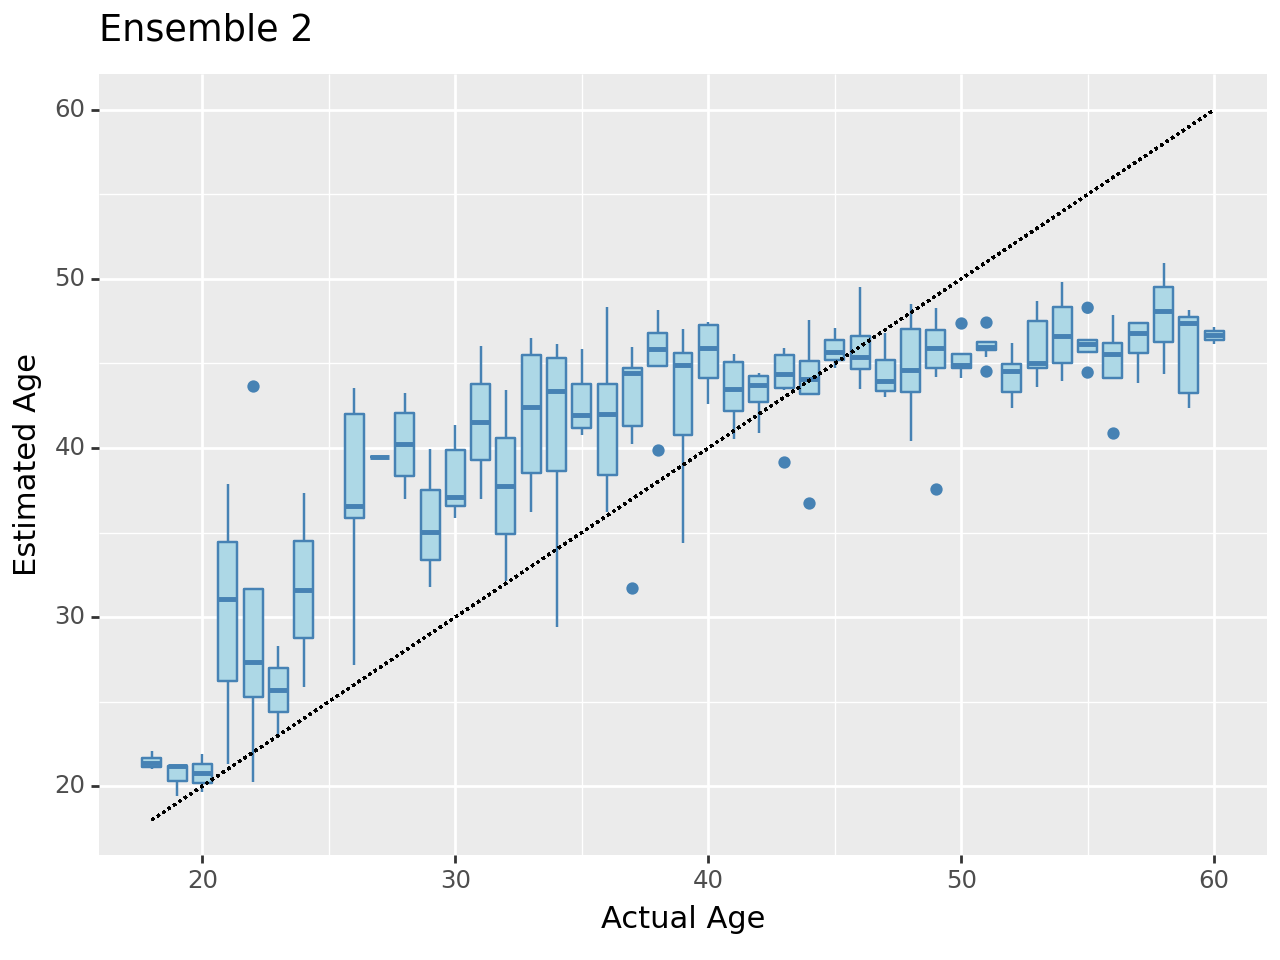

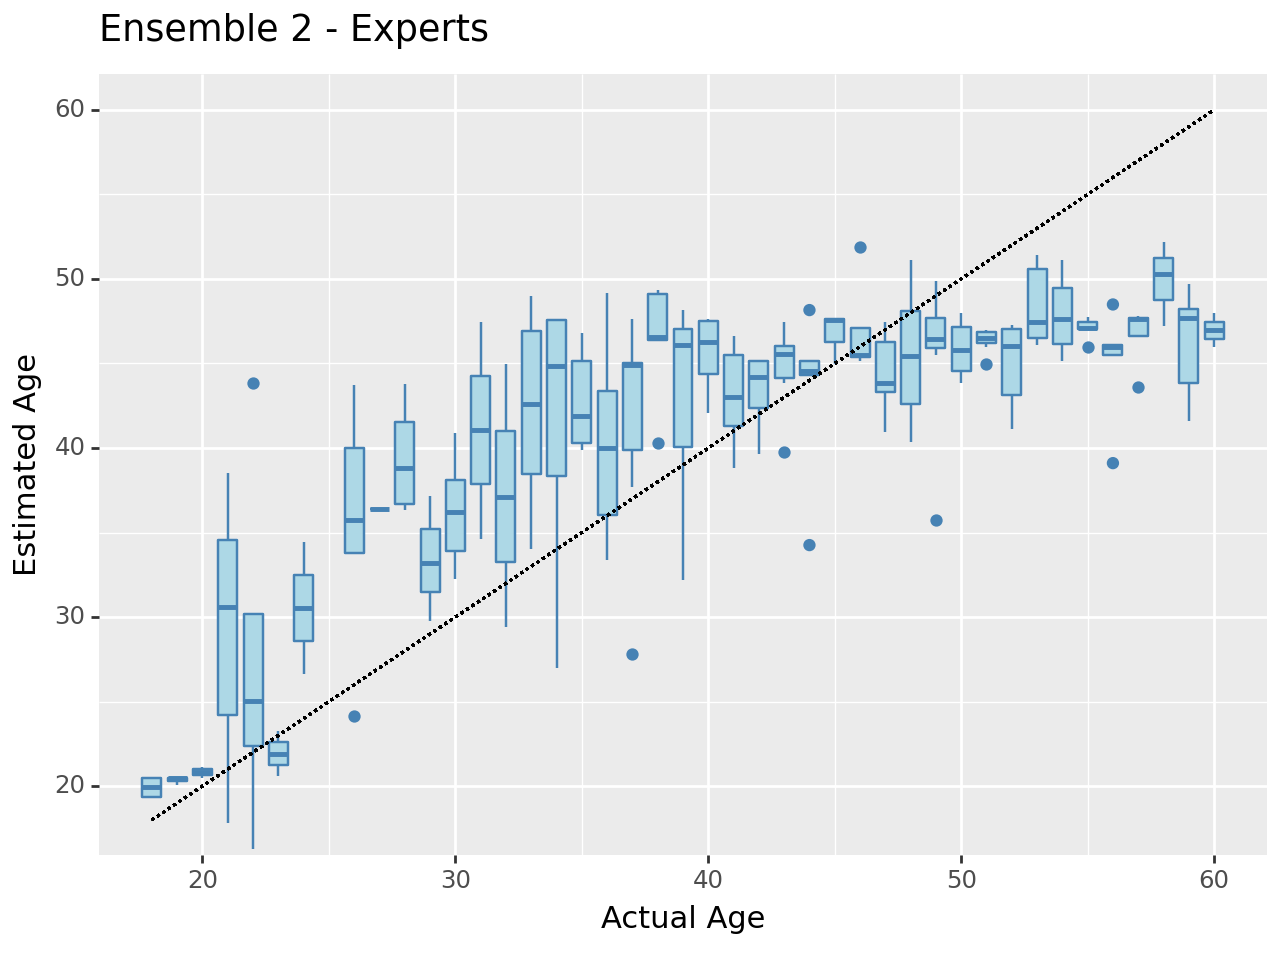

In [59]:


p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensembleWAE2}),'Ensemble 2')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensembleWAE2_pruned}),'Ensemble 2 - Experts')
print(p)

### RAE3: Ranked Weighted Average by validation score

In [60]:
scores={x: SR_train_results[x]['R2_score'] for x,y in  data_eval['X_train'].items()}

scores.pop('Agg_data')
scores.pop('Expert_data')
scores.pop('avg_all')

scores.pop('avg_exp')
print(scores)

sorted_indices = sorted(scores, key=lambda k: scores[k])

sorted_idx=[sorted_indices.index(x)+1 for x in scores.keys()]

ws=np.array(sorted_idx)
normalized_weights = normalize(ws.reshape(1, -1), norm='l1')[0]
print(ws)
print(normalized_weights)
RWE3_test_pred_ensemble=(test_pred_E1*normalized_weights[0]+test_pred_E2*normalized_weights[1]+test_pred_M1*normalized_weights[2]+test_pred_M2*normalized_weights[3])

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],RWE3_test_pred_ensemble)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],RWE3_test_pred_ensemble)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],RWE3_test_pred_ensemble,squared=False)
   

RWE3_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating 4 labels',RWE3_test_results)

{'E1': 0.5344414450945257, 'E2': 0.5489587979548843, 'M1': 0.3664850840885976, 'M2': 0.3710639076505512}
[3 4 1 2]
[0.3 0.4 0.1 0.2]
Aggregating 4 labels {'mae': 6.277156580298931, 'mse': 57.721125753560834, 'rmse': 7.5974420533203695}


In [61]:
scores={'E1':SR_train_results['E1']['R2_score'],'E2':SR_train_results['E2']['R2_score']}



sorted_indices = sorted(scores, key=lambda k: scores[k])

sorted_idx=[sorted_indices.index(x)+1 for x in scores.keys()]

ws=np.array(sorted_idx)
normalized_weights = normalize(ws.reshape(1, -1), norm='l1')[0]
RWE3_test_pred_ensemble_pruned=(test_pred_E1*normalized_weights[0]+test_pred_E2*normalized_weights[1])

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],RWE3_test_pred_ensemble_pruned)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],RWE3_test_pred_ensemble_pruned)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],RWE3_test_pred_ensemble_pruned,squared=False)
   

RWE3_test_results_pruned={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating Experts',RWE3_test_results_pruned)

Aggregating Experts {'mae': 6.083492559278362, 'mse': 56.63107643611566, 'rmse': 7.525362212951325}


### Best Model Equation

In [62]:
fused_equation=normalized_weights[0]*simplified_equations['E1']+normalized_weights[0]*simplified_equations['E2']
final_equation=sympify((fused_equation), locals=converter)
rounded_equation=final_equation
#round numbers
for a in preorder_traversal(final_equation): 
    if isinstance(a, Float):
        rounded_equation = rounded_equation.subs(a, round(a, 2))
rounded_equation

0.67*X0 + 1.0*X1 + 2.33*X2 + 0.33*X3/X5 - 1.0*X4 + 3.88*X4/(-X2 + X4) + 6.47*X5 + 0.33*X5/(-X5 + X8/X4) + 1.33*X8 + 1.88 - 0.33/(-X5 + X7 - 0.48) - 0.33/(X5 - 0.6) - 0.08/X7 + 0.33*(X2 + X3)*(X0/X5**2 + X1)/X5 + 0.33*X8/X4 + 3.88*X4/(X3*(X5 + X8)) + 0.33/(X1*X2) + 0.33/(X1*X2*X5)

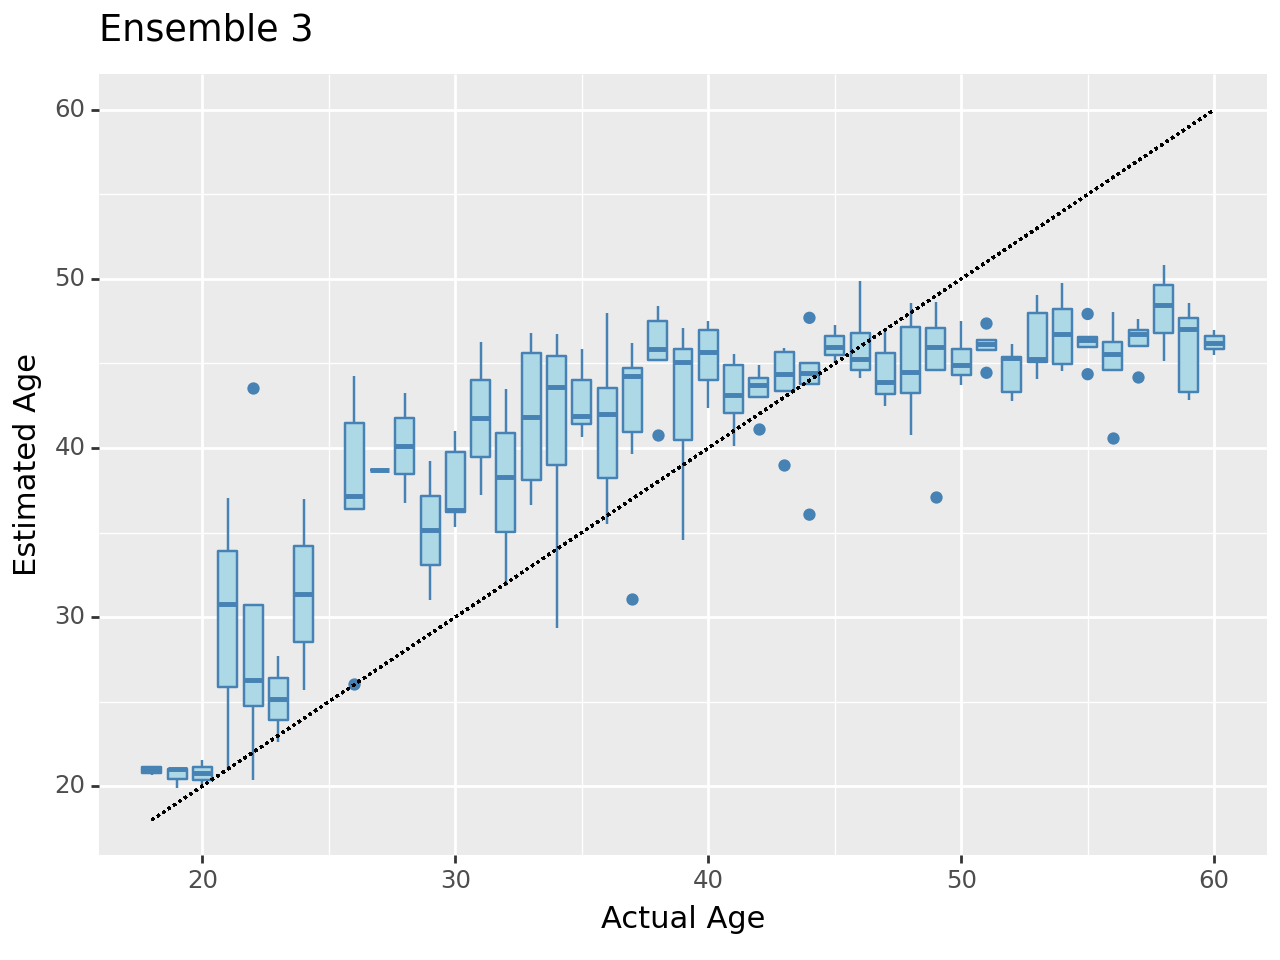

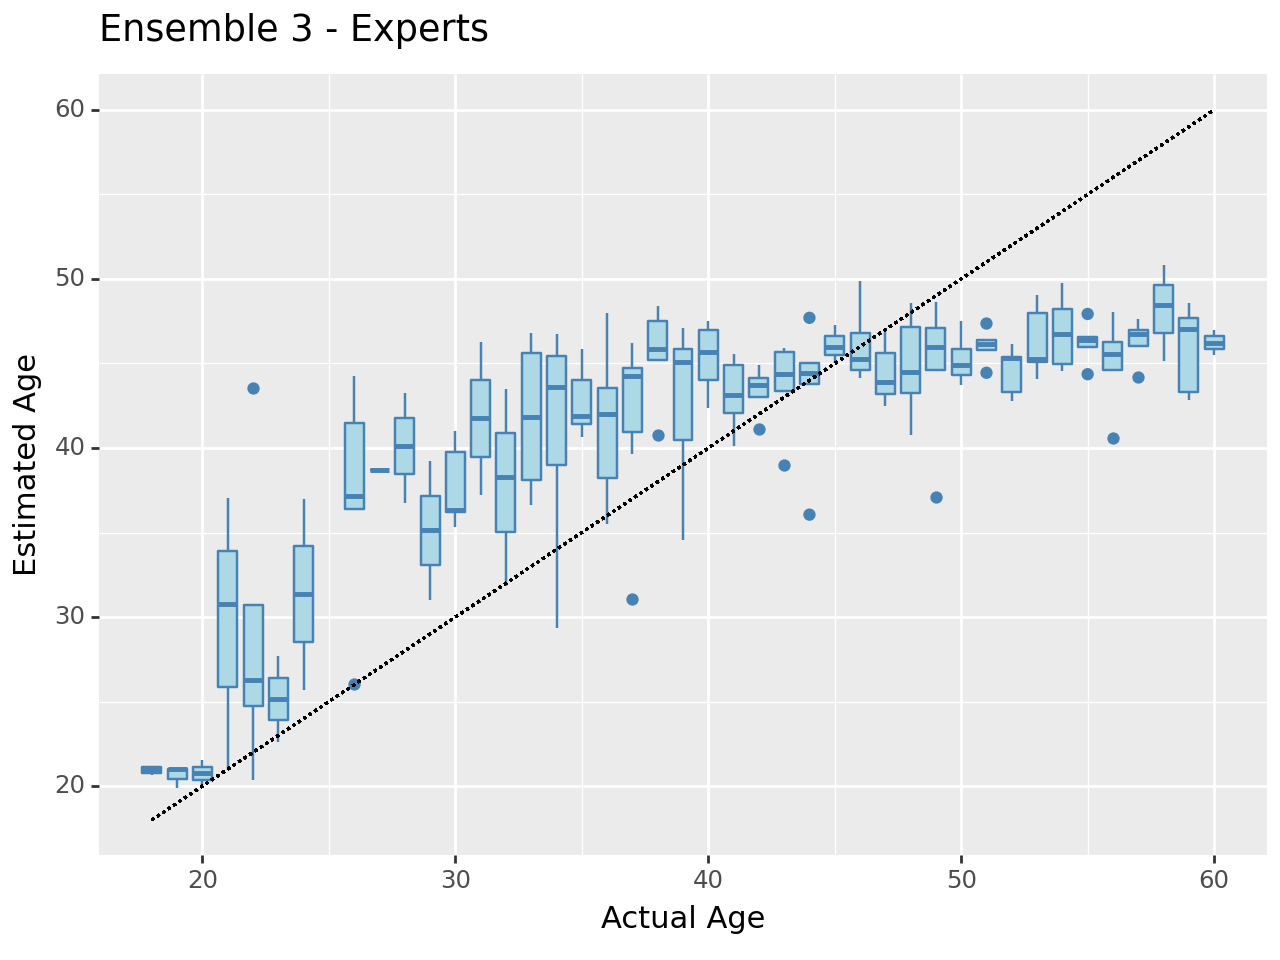

In [63]:


p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':RWE3_test_pred_ensemble}),'Ensemble 3')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':RWE3_test_pred_ensemble}),'Ensemble 3 - Experts')
print(p)

### FIE: Fuzzy operator OWA

In [64]:

predictions=np.array([test_pred_E1,test_pred_E2,test_pred_M1,test_pred_M2])

FIE4_test_pred_ensemble=owas.OWA3(predictions,axis=0,keepdims=False)

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble,squared=False)
   
FIE4_test_results={ 'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse }
print('Aggregating 4 labels',FIE4_test_results)

Aggregating 4 labels {'mae': 6.431418964620852, 'mse': 60.25663613276004, 'rmse': 7.762514807249004}


In [65]:


predictions=np.array([test_pred_E1,test_pred_E2])

FIE4_test_pred_ensemble_pruned=owas.OWA3(predictions,axis=0,keepdims=False)

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble_pruned)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble_pruned)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble_pruned,squared=False)
   

FIE4_test_results_pruned={ 'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse }
print('Aggregating Experts',FIE4_test_results_pruned)

Aggregating Experts {'mae': 6.111341667785726, 'mse': 56.726304568186166, 'rmse': 7.531686701409331}


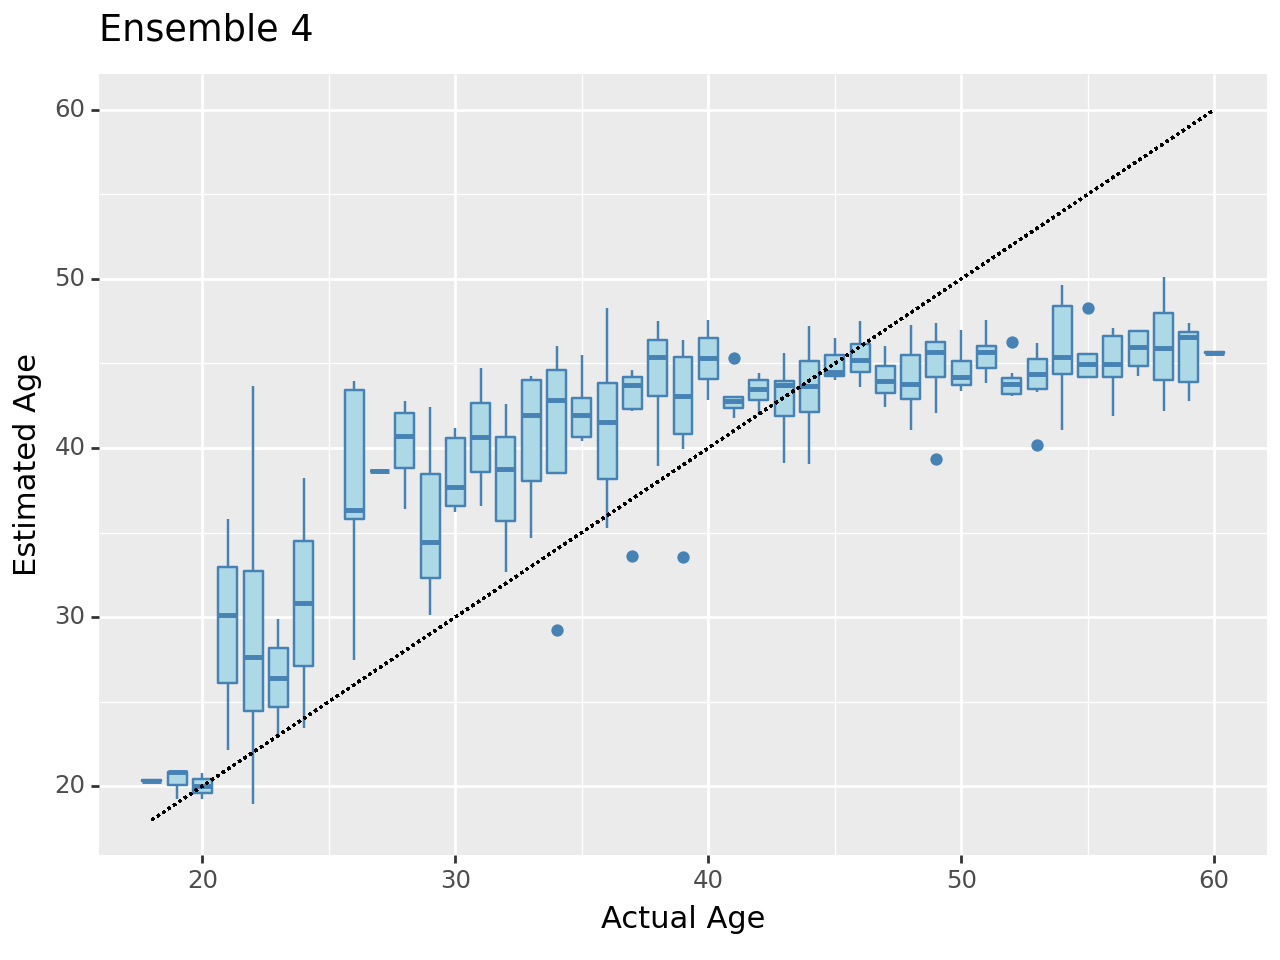

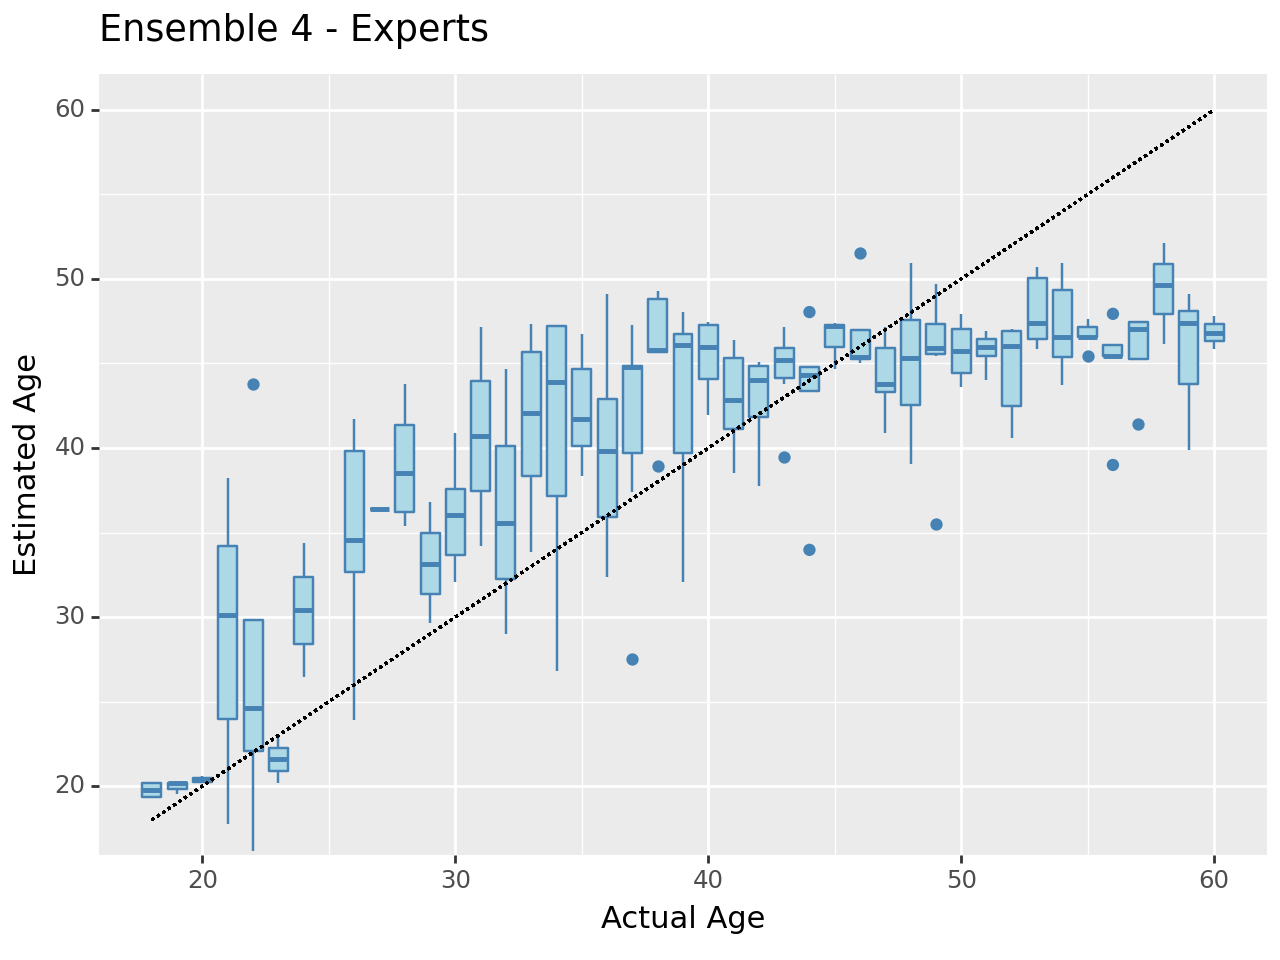

In [66]:


p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':FIE4_test_pred_ensemble}),'Ensemble 4')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':FIE4_test_pred_ensemble_pruned}),'Ensemble 4 - Experts')
print(p)


### FIE: Fuzzy operator Choquet integral


In [67]:
predictions=np.array([test_pred_E1,test_pred_E2,test_pred_M1,test_pred_M2])
arr_t = predictions.T

FIE4_test_pred_ensemble2=integrals.choquet_integral_CF(predictions,axis=0,keepdims=False)

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble2)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble2)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble2,squared=False)
   
FIE4_test_results2={ 'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating 4 labels',FIE4_test_results2)

Aggregating 4 labels {'mae': 6.4609438186764425, 'mse': 62.61356263605809, 'rmse': 7.912873222544267}


In [68]:


predictions=np.array([test_pred_E1,test_pred_E2])

FIE4_test_pred_ensemble2_pruned=integrals.choquet_integral_CF(predictions,axis=0,keepdims=False)

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble2_pruned)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble2_pruned)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],FIE4_test_pred_ensemble2_pruned,squared=False)
   
FIE4_test_results2_pruned={ 'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating Experts',FIE4_test_results2_pruned)

Aggregating Experts {'mae': 6.176232835962526, 'mse': 59.18628184519971, 'rmse': 7.693262106882861}


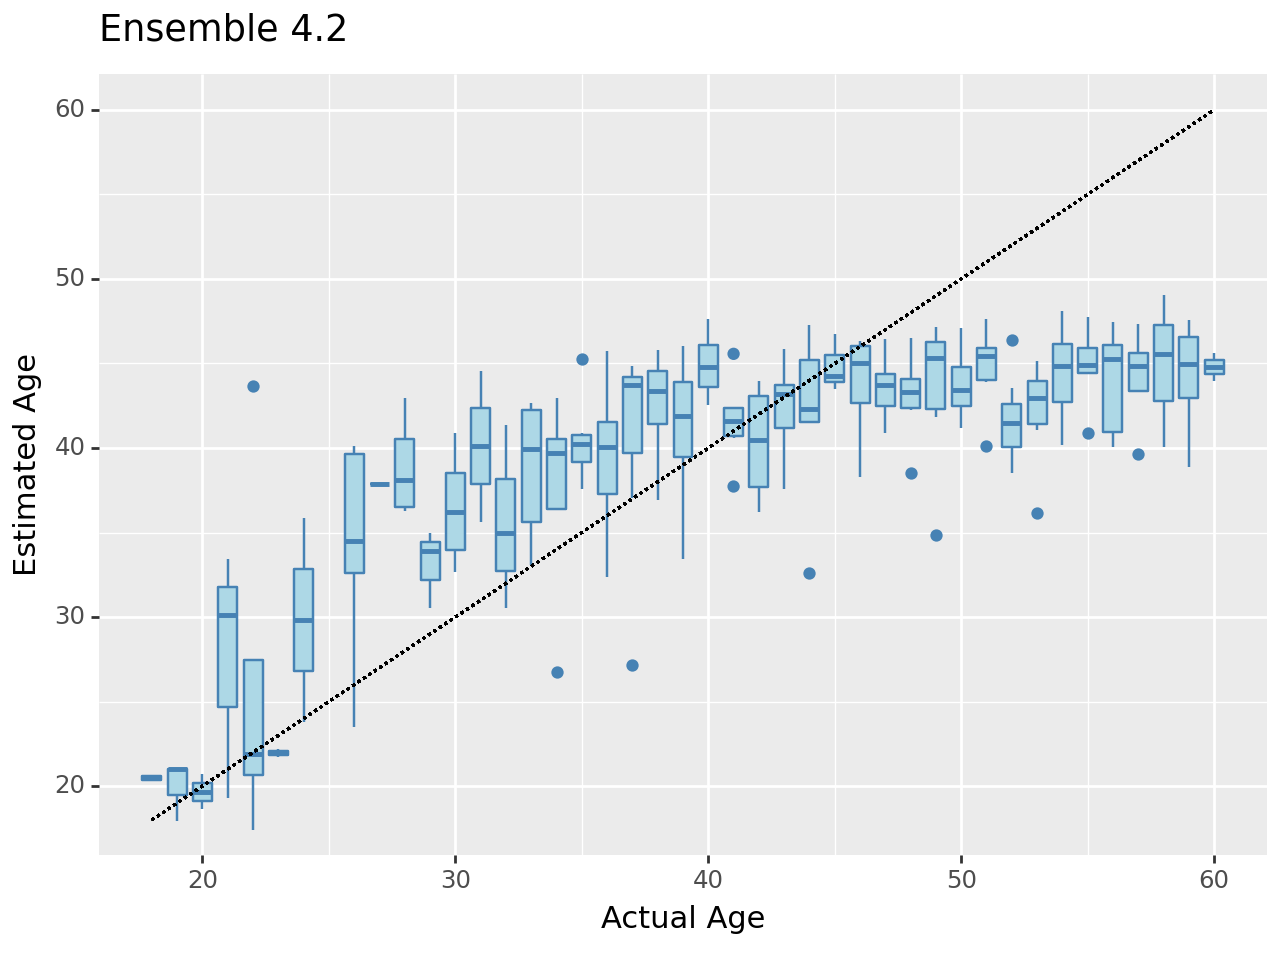

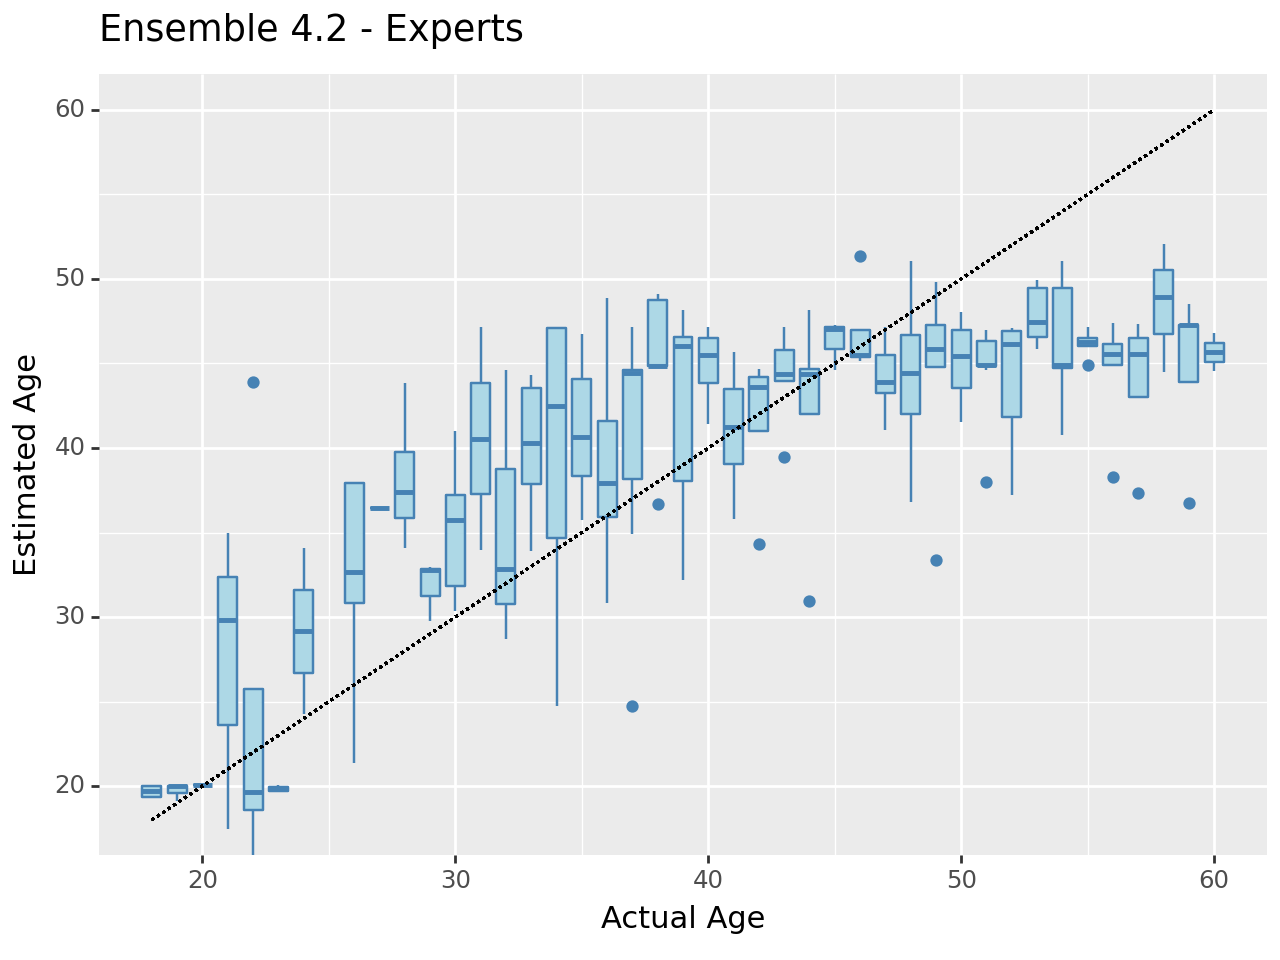

In [69]:

p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':FIE4_test_pred_ensemble2}),'Ensemble 4.2')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':FIE4_test_pred_ensemble2_pruned}),'Ensemble 4.2 - Experts')
print(p)



### Summary

In [70]:
print("Base - Expert 1:                     ",SR_test_results['E1'])
print("Base - Expert 2:                     ",SR_test_results['E2'])
print("Base - Master's 1 :                  ",SR_test_results['M1'])
print("Base - Master's 2 :                  ",SR_test_results['M2'])
print("Aggregated:                          ",SR_test_results['Agg_data'])
print("Experts:                             ",SR_test_results['Expert_data'])
print("Averaged:                            ",SR_test_results['avg_all'])
print("Averaged Experts:                    ",SR_test_results['avg_exp'])

print("Ensembles all weak learners:")
print('E1 - Simple average:                 ',SAE1_test_results)
print('E2 - weighted average:               ',WAE2_test_results)
print('E3 - weights by score rank:          ',RWE3_test_results)
print('E4 - OWA3:                           ',FIE4_test_results)

print('Ensembles with only two experts')
print('E1 - Simple average:                 ',SAE1_test_results_pruned)
print('E2 - weighted average:               ',WAE2_test_results_pruned)
print('E3 - weights by score rank:          ',RWE3_test_results_pruned)
print('E4 - OWA3:                           ',FIE4_test_results_pruned)





Base - Expert 1:                      {'mae': 6.611699336942163, 'rmse': 8.152097432583801}
Base - Expert 2:                      {'mae': 6.196953602084002, 'rmse': 7.767587777446707}
Base - Master's 1 :                   {'mae': 7.692395114517578, 'rmse': 9.208711043770798}
Base - Master's 2 :                   {'mae': 7.399510131004906, 'rmse': 8.913666242715125}
Aggregated:                           {'mae': 7.0521982175851905, 'rmse': 8.609501751249404}
Experts:                              {'mae': 6.397595451369475, 'rmse': 7.9505066196825345}
Averaged:                             {'mae': 6.733503541140149, 'rmse': 8.29376131526728}
Averaged Experts:                     {'mae': 6.3212954347623755, 'rmse': 7.972873168376423}
Ensembles all weak learners:
E1 - Simple average:                  {'mae': 6.561341245601311, 'mse': 61.20831213872203, 'rmse': 7.82357412815409}
E2 - weighted average:                {'mae': 6.3594384286354, 'mse': 58.609208921073545, 'rmse': 7.655665152099688}

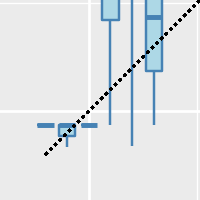

In [71]:
import patchworklib as pw

best=[SR_test_predictions['E1'],SR_test_predictions['E2'],SR_test_predictions['M1'],SR_test_predictions['M2'],RWE3_test_pred_ensemble,RWE3_test_pred_ensemble]
names=['Expert 1','Expert 2', 'Master\'s 1','Master\'s 2','Best Ensemble (RWE)- No pruning','Best Ensemble (RWE)- Pruning']
eval_set=['E1','E2','M1','M2','E2','E2']

p_list=[]
for i in range(len(best)):
    p=generate_plot(pd.DataFrame({'Age': data_eval['y_test'][eval_set[i]], 'prediction':best[i]}),names[i])
    g2 = pw.load_ggplot(p, figsize=(5,5))
    p_list.append(g2)


gfig=(p_list[2].outline|p_list[3].outline|p_list[4].outline)/(p_list[0].outline|p_list[1].outline|p_list[5].outline)
gfig.savefig("Results.svg")


